<font size="+3"><strong>4.5. Earthquake Damage in Kavrepalanchok 🇳🇵</strong></font>

In this assignment, you'll build a classification model to predict building damage for the district of [Kavrepalanchok](https://en.wikipedia.org/wiki/Kavrepalanchok_District).

In [17]:
import warnings


warnings.simplefilter(action="ignore", category=FutureWarning)

In [18]:
# Import libraries here
import sqlite3
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from category_encoders import OneHotEncoder,OrdinalEncoder
from IPython.display import VimeoVideo
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Connect

Run the cell below to connect to the `nepal.sqlite` database.

In [19]:
%load_ext sql
%config SqlMagic.autopandas = True

%sql sqlite:///nepals.sqlite

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


<div class="alert alert-block alert-warning">
<b>Warning:</b>Be careful with your SQL queries in this assignment. If you try to get all the rows from a table (for example, <code>SELECT * FROM id_map</code>), you will cause an Out of Memory error on your virtual machine. So always include a <code>LIMIT</code> when first exploring a database.
</div>

**Task 4.5.1:** What districts are represented in the `id_map` table? Determine the unique values in the **`district_id`** column.

In [20]:
%sql SELECT DISTINCT(district_id) FROM id_map LIMIT 5


 * sqlite:///nepals.sqlite
Done.


,district_id
0,1
1,2
2,3
3,4


What's the district ID for Kavrepalanchok? From the lessons, you already know that Gorkha is `4`; from the textbook, you know that Ramechhap is `2`. Of the remaining districts, Kavrepalanchok is the one with the largest number of observations in the `id_map` table.

**Task 4.5.2:** Calculate the number of observations in the `id_map` table associated with district `1`.

In [21]:
%%sql
SELECT COUNT(*)
FROM id_map
WHERE district_id = 1


 * sqlite:///nepals.sqlite
Done.


,COUNT(*)
0,36112


**Task 4.5.3:** Calculate the number of observations in the `id_map` table associated with district `3`.

In [22]:
%%sql
SELECT COUNT(*)
FROM id_map
WHERE district_id = 3

 * sqlite:///nepals.sqlite
Done.


,COUNT(*)
0,82684


**Task 4.5.4:** Join the unique building IDs from Kavrepalanchok in `id_map`, all the columns from  `building_structure`, and the **`damage_grade`** column from `building_damage`, limiting. Make sure you rename the **`building_id`** column in `id_map` as **`b_id`** and limit your results to the first five rows of the new table.

In [23]:
%%sql
SELECT *
FROM id_map
LIMIT 5

 * sqlite:///nepals.sqlite
Done.


,household_id,building_id,vdcmun_id,district_id
0,5601,56,7,1
1,6301,63,7,1
2,9701,97,7,1
3,9901,99,7,1
4,11501,115,7,1


In [24]:
%%sql
SELECT idm.building_id AS b_id,
        bs.*,
        bd.damage_grade
        

FROM id_map AS idm

JOIN building_structure AS bs
ON idm.building_id = bs.building_id

JOIN building_damage AS bd
ON bs.building_id = bd.building_id
 

WHERE district_id = 3

LIMIT 5

 * sqlite:///nepals.sqlite
Done.


,b_id,building_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,condition_post_eq,superstructure,damage_grade
0,87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
1,87473,87473,2,1,15,382,18,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Used in risk,"Stone, mud mortar",Grade 4
2,87479,87479,1,0,12,328,7,0,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,Damaged-Rubble clear,"Stone, mud mortar",Grade 5
3,87482,87482,2,1,23,427,20,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4
4,87491,87491,2,1,12,427,14,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,Damaged-Not used,"Stone, mud mortar",Grade 4


## Import

**Task 4.5.5:** Write a `wrangle` function that will use the query you created in the previous task to create a DataFrame. In addition your function should:

1. Create a `"severe_damage"` column, where all buildings with a damage grade greater than `3` should be encoded as `1`. All other buildings should be encoded at `0`. 
2. Drop any columns that could cause issues with leakage or multicollinearity in your model.

In [25]:
# Build your `wrangle` function here
def wrangle(db_path):
    #connect to database
    conn = sqlite3.connect(db_path)
    
    #Construct query
    query="""
    SELECT idm.building_id AS b_id,
        bs.*,
        bd.damage_grade
        

    FROM id_map AS idm

    JOIN building_structure AS bs
        ON idm.building_id = bs.building_id

    JOIN building_damage AS bd
        ON bs.building_id = bd.building_id


    WHERE district_id = 3
    """
    
    #Read query result intos into Dataframe
    df = pd.read_sql(query,conn,index_col="b_id")
    
    # Identify leaky columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Add high-cardinality / redundant column
    drop_cols.append("building_id")

    # Create binary target column
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop old target
    drop_cols.append("damage_grade")

    # Drop multicollinearity column
    drop_cols.append("count_floors_pre_eq")
    
    # Drop columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

Use your `wrangle` function to query the database at `"/home/jovyan/nepal.sqlite"` and return  your cleaned results.

In [26]:
df = wrangle("nepals.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87473,15,382,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87479,12,328,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,"Stone, mud mortar",1
87482,23,427,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1
87491,12,427,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",1




## Explore

**Task 4.5.6:** Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column. Be sure to label the x-axis `"Severe Damage"` and the y-axis `"Relative Frequency"`. Use the title `"Kavrepalanchok, Class Balance"`.
**Task 4.5.6:** Are the classes in this dataset balanced? Create a bar chart with the normalized value counts from the `"severe_damage"` column. Be sure to label the x-axis `"Severe Damage"` and the y-axis `"Relative Frequency"`. Use the title `"Kavrepalanchok, Class Balance"`.

Text(0.5, 1.0, 'Kavrepalanchok, Class Balance')

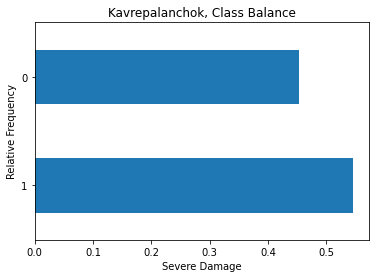

In [27]:
# Plot value counts of `"severe_damage"`
severe_chart =df["severe_damage"].value_counts(normalize=True)
severe_chart.plot(kind="barh")
plt.xlabel("Severe Damage")
plt.ylabel("Relative Frequency")
plt.title("Kavrepalanchok, Class Balance")

# Don't delete the code below 👇
#plt.savefig("images/4-5-6.png", dpi=150)


**Task 4.5.7:** Is there a relationship between the footprint size of a building and the damage it sustained in the earthquake? Use seaborn to create a boxplot that shows the distributions of the `"plinth_area_sq_ft"` column for both groups in the `"severe_damage"` column. Label your x-axis `"Severe Damage"` and y-axis `"Plinth Area [sq. ft.]"`. Use the title `"Kavrepalanchok, Plinth Area vs Building Damage"`. 

Text(0.5, 1.0, 'Kavrepalanchok, Plinth Area vs Building Damage')

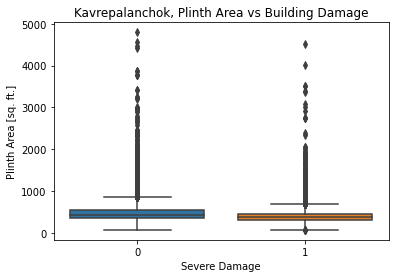

In [28]:
severe_box = sns.boxplot(x=df["severe_damage"],y=df["plinth_area_sq_ft"])
severe_box.set_xlabel("Severe Damage")
severe_box.set_ylabel("Plinth Area [sq. ft.]")
severe_box.set_title("Kavrepalanchok, Plinth Area vs Building Damage")
# Don't delete the code below 👇
#plt.savefig("images/4-5-7.png", dpi=150)


**Task 4.5.8:** Are buildings with certain roof types more likely to suffer severe damage? Create a pivot table of `df` where the index is `"roof_type"` and the values come from the `"severe_damage"` column, aggregated by the mean.

In [29]:
roof_pivot = pd.pivot_table(df,
                            index=['roof_type'],
                            values='severe_damage',
                            aggfunc='mean'
)
roof_pivot

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.568324
Bamboo/Timber-Light roof,0.604864
RCC/RB/RBC,0.041575


## Split

**Task 4.5.9:** Create your feature matrix `X` and target vector `y`. Your target is `"severe_damage"`. 

In [79]:
target= "severe_damage"
X_train = df.drop(columns=[target])
y_train = df[target]
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (82684, 11)
y shape: (82684,)


**Task 4.5.10:** Divide your dataset into training and validation sets using a randomized split. Your validation set should be 20% of your data.

In [81]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train,y_train,test_size=0.2, random_state=42
)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (52917, 11)
y_train shape: (52917,)
X_val shape: (13230, 11)
y_val shape: (13230,)


# Build Model

## Baseline

**Task 4.5.11:** Calculate the baseline accuracy score for your model.

In [82]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.55


## Iterate

**Task 4.5.12:** Create a model `model_lr` that uses logistic regression to predict building damage. Be sure to include an appropriate encoder for categorical features. 

In [83]:
#build model
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000)
    
)
#fit model to trainning data
model_lr.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['land_surface_condition',
                                     'foundation_type', 'roof_type',
                                     'ground_floor_type', 'other_floor_type',
                                     'position', 'plan_configuration',
                                     'superstructure'],
                               use_cat_names=True)),
                ('logisticregression', LogisticRegression(max_iter=1000))])

**Task 4.5.13:** Calculate training and validation accuracy score for `model_lr`. 

In [84]:
lr_train_acc = model_lr.score(X_train,y_train)
lr_val_acc = model_lr.score(X_val,y_val)

print("Logistic Regression, Training Accuracy Score:", lr_train_acc)
print("Logistic Regression, Validation Accuracy Score:", lr_val_acc)

Logistic Regression, Training Accuracy Score: 0.6523612449685356
Logistic Regression, Validation Accuracy Score: 0.6523053665910808


**Task 4.5.14:** Perhaps a decision tree model will perform better than logistic regression, but what's the best hyperparameter value for `max_depth`? Create a `for` loop to train and evaluate the model `model_dt` at all depths from 1 to 15. Be sure to use an appropriate encoder for your model, and to record its training and validation accuracy scores at every depth. The grader will evaluate your validation accuracy scores only.

In [85]:
depth_hyperparams = range(1, 16)
training_acc = []
validation_acc = []
for d in depth_hyperparams:
    model_dt = make_pipeline(
                        OrdinalEncoder(),
                        DecisionTreeClassifier(max_depth=d, random_state=42)
    )
    model_dt.fit(X_train, y_train)
    training_acc.append(model_dt.score(X_train,y_train))
    validation_acc.append(model_dt.score(X_val,y_val))

In [86]:


print("Trainging acc : ",training_acc)
print("Validation acc : ",validation_acc)

Trainging acc :  [0.6336527014003062, 0.6365818168074532, 0.6436305913033619, 0.6553659504507058, 0.656499801576053, 0.6612619763025115, 0.66458793960353, 0.6712398662055672, 0.6776272275450234, 0.6859988283538372, 0.6954664852504866, 0.7064648411663549, 0.7182190978324546, 0.7329024699057014, 0.7485307179167375]
Validation acc :  [0.6387755102040816, 0.6431594860166289, 0.6486772486772486, 0.6575207860922146, 0.6589569160997732, 0.6608465608465608, 0.6609221466364323, 0.6647770219198791, 0.6620559334845049, 0.6654572940287226, 0.6637944066515495, 0.663114134542706, 0.664474678760393, 0.663114134542706, 0.6585034013605442]


**Task 4.5.15:** Using the values in `training_acc` and `validation_acc`, plot the validation curve for `model_dt`. Label your x-axis `"Max Depth"` and your y-axis `"Accuracy Score"`. Use the title `"Validation Curve, Decision Tree Model"`, and include a legend. 

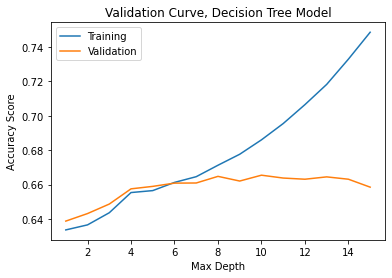

In [87]:

# Don't delete the code below 👇
plt.plot(depth_hyperparams,training_acc,label="Training")
plt.plot(depth_hyperparams,validation_acc,label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.title("Validation Curve, Decision Tree Model")
plt.legend()

plt.savefig("images/4-5-15.png", dpi=150)


**Task 4.5.16:** Build and train a new decision tree model `final_model_dt`, using the value for `max_depth` that yielded the best validation accuracy score in your plot above. 

In [91]:
final_model_dt = make_pipeline(
                OrdinalEncoder(),
                DecisionTreeClassifier(max_depth=10,random_state=42)
)
final_model_dt.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
U-shape                             9
Building with Central Courtyard    10
NaN                                -2
dtype: int64},
                                         {'col': 'superstructure',
                                          'data_type': dtype('O'),
                                          'mapping': Stone, mud mortar        1
RC, non-engineered       2
Adobe/mud                3
Brick, cement mortar     4
Brick, mud mortar        5
RC, engineered           6
Stone, cement mortar     7
Stone                    8
Other                    9
Timber                  10
Bamboo                  11
NaN                     -2
dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

## Evaluate

**Task 4.5.17:** How does your model perform on the test set? First, read the CSV file `"data/kavrepalanchok-test-features.csv"` into the DataFrame `X_test`. Next, use `final_model_dt` to generate a list of test predictions `y_test_pred`. Finally, submit your test predictions to the grader to see how your model performs.

**Tip:** Make sure the order of the columns in `X_test` is the same as in your `X_train`. Otherwise, it could hurt your model's performance.

In [93]:
X_test = pd.read_csv("data/kavrepalanchok-test-features.csv", index_col="b_id")
y_test_pred = final_model_dt.predict(X_test)
y_test_pred[:5]

array([1, 1, 1, 1, 0])

# Communicate Results

**Task 4.5.18:** What are the most important features for `final_model_dt`? Create a Series Gini `feat_imp`, where the index labels are the feature names for your dataset and the values are the feature importances for your model. Be sure that the Series is sorted from smallest to largest feature importance. 

In [99]:
features = final_model_dt.named_steps["ordinalencoder"].get_feature_names()
importances = final_model_dt.named_steps["decisiontreeclassifier"].feature_importances_
feat_imp = pd.Series(importances,index=features).sort_values()
feat_imp

plan_configuration        0.002818
ground_floor_type         0.007866
position                  0.010045
land_surface_condition    0.017048
roof_type                 0.019576
other_floor_type          0.032909
plinth_area_sq_ft         0.088159
age_building              0.118910
height_ft_pre_eq          0.125346
superstructure            0.127696
foundation_type           0.449628
dtype: float64

**Task 4.5.19:** Create a horizontal bar chart of `feat_imp`. Label your x-axis `"Gini Importance"` and your y-axis `"Label"`. Use the title `"Kavrepalanchok Decision Tree, Feature Importance"`.

Do you see any relationship between this plot and the exploratory data analysis you did regarding roof type?

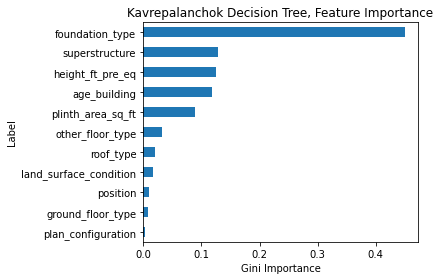

In [100]:
# Create horizontal bar chart of feature importances

feat_imp.plot(kind="barh")
plt.xlabel("Gini Importance")
plt.ylabel("Label")
plt.title("Kavrepalanchok Decision Tree, Feature Importance")

# Don't delete the code below 👇
plt.tight_layout()
plt.savefig("images/4-5-19.png", dpi=150)


Congratulations! You made it to the end of Project 4. 👏👏👏